# ID 5059 Coursework 1
John Belcher-Heath (jbh6)

# Introduction

The task is to predict the price of a car from a subset of attributes from the Kaggle dataset.

I will complete the task following the ML checklist in the book, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. which is:

1. Frame the problem
2. Get the data
3. Explore the data
4. Prepare the data
5. Explore models
6. Fine-tune models
7. Present solution
8. Launch/maintain

1 has already been done; we want to predict price of a car using attributes available to us.

# 2. Get the data

In the section the a random sleection of entries from one of the large datasets will be obtained and read into a pandas.dataframe to explore. A random selection of the large dataset will be explored since all we are doing is getting to know the data. Having a large amount of data to explore will be time consuming, but having too small (and non random sample) will mean our observations may not be valid. Taking a sample of a large dataset should give a relatively good representation of the overall dataset, whilst minimising the amount of data requiring to be manipulated.

Note when it comes to applying the model I will include a check of the data to make sure our observations on the smaller dataset still hold.

In [3]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scikit-learn | grep -v 'already satisfied'

# Import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import sklearn
import os
import glob
from pathlib import Path

In [4]:
# folder_path: str = "/cs/studres/ID5059/Coursework/Coursework-1/data/2_medium" # uni
folder_path : str = r"/home/johnbh/personal_git/ID5059_coursework_1/data/2_medium" # Desktop

if not os.path.exists(folder_path):
    raise FileNotFoundError
os.chdir(folder_path)

file_names : list = [i for i in glob.glob("*.{}".format('csv'))]

def read_car_data(filepath : str) -> pd.DataFrame:
    """
    Reads a filepath and returns the dataframe
    :param filepath: The location of the file to read
    :return: returns the pandas dataframe
    """
    return pd.read_csv(filepath, index_col = "vin")

df = read_car_data(file_names[0]) # Read one of the medium files
data_original_length : int = len(df.index)

In [5]:
# os.chdir(folder_path)
# file_names : list = [i for i in glob.glob("*.{}".format('csv'))]
# df = pd.concat(map(read_car_data, file_names))


# 3. Explore the data

The data will now be inspected to explore what attributes are available to use. Additionally, with this output, attributes with large proportion of NAs can be identified and removed.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25951 entries, ZACNJABB5KPJ92081 to 2T1BURHE3HC840759
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   back_legroom             24549 non-null  object 
 1   bed                      237 non-null    object 
 2   bed_height               1677 non-null   object 
 3   bed_length               1677 non-null   object 
 4   body_type                25829 non-null  object 
 5   cabin                    276 non-null    object 
 6   city                     25951 non-null  object 
 7   city_fuel_economy        22046 non-null  float64
 8   combine_fuel_economy     0 non-null      float64
 9   daysonmarket             25951 non-null  int64  
 10  dealer_zip               25951 non-null  int64  
 11  description              25441 non-null  object 
 12  engine_cylinders         25188 non-null  object 
 13  engine_displacement      24427 non-null  float64
 14 

Let's explore all the numerical attributes with an actual numerical meaning.(index or listing_id have no meaning numerically).

Firstly though, let's drop all attributes from above which have less than 20% non-null values, since including these may negatively effect our model if a majority of entries do not have this attribute.

In [7]:
# Drop all attributes with less than 10% non-null values
df = df.drop(columns=df.keys()[df.count() / len(df.index) < 0.2])

Drop attributes with no numerical meaning for the next section

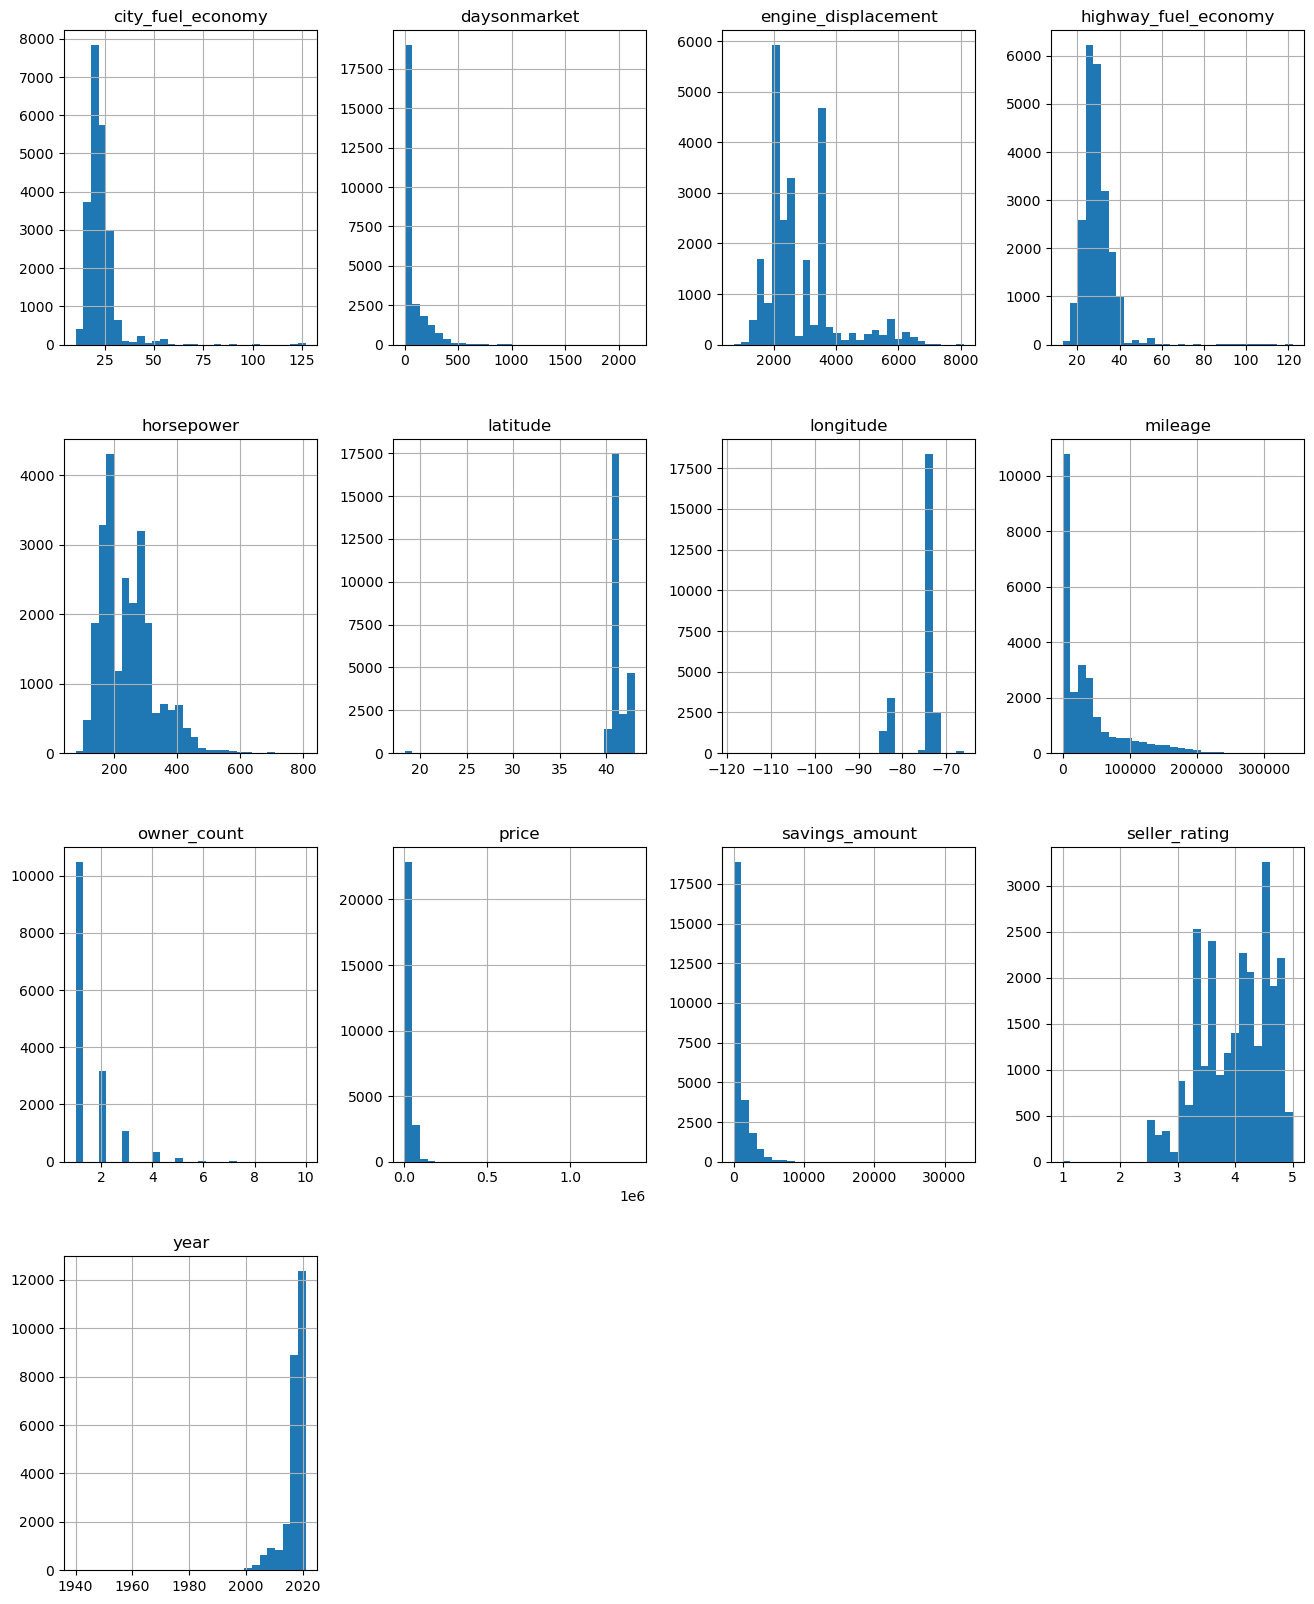

In [8]:
import matplotlib.pyplot as mpl
%matplotlib inline

df_numerical = df.select_dtypes(include=[np.int64, np.float64]).drop(columns=['dealer_zip', 'listing_id', 'sp_id'])
df_numerical.hist(figsize=(16,20), bins=30)
mpl.show()

Observations:
- Both fuel economy attributes appear to be normally distributed with a slight skew
- Majority of cars do not stay on the market for a long duration, mostly less than a couple of months. Some may be above a large amount so these may need to be removed to not skew data.
- Engine displacement doesn't appear to have any obvious standard distribution
- Horsepower appears to have a normal distribution around 200hp with a standard deviation of around 50hp
- Lattitude is as expected all grouped together around 39 to 44 
- longitutde is split into two peaks, most likely corresponding to central US and alaska
- Milegae of most cars is grouped mostly around 0 and fewer cars with higher mileage, as would be expected
- owner count has a modal of 1, again as to be expected
- Most cars prices are group around the same order of magnitutde. Howeever some extremes are seen. A logarithmic transformation may need to be considered later.
- Seller ratings appear to be skew negatively towards the higher end
- Majority of cars are from the last 15 years

Now let's examine the qualatitative data.

In [9]:
df_qualitative = df.select_dtypes(include=object)

In [10]:
df_qualitative.head(10)

,back_legroom,body_type,city,description,engine_cylinders,engine_type,exterior_color,fleet,frame_damaged,franchise_make,...,theft_title,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width
vin,,,,,,,,,,,,,,,,,,,,,
ZACNJABB5KPJ92081,35.1 in,SUV / Crossover,Bayamon,[!@@Additional Info@@!]Engine: 2.4L I4 ZERO EV...,I4,I4,Solar Yellow,NaN,NaN,Jeep,...,NaN,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,t83804,Latitude FWD,FWD,Front-Wheel Drive,101.2 in,79.6 in
SALCJ2FX1LH858117,38.1 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",I4,I4,Narvik Black,NaN,NaN,Land Rover,...,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,AWD,All-Wheel Drive,107.9 in,85.6 in
JF1VA2M67G9829723,35.4 in,Sedan,Guaynabo,NaN,H4,H4,None,False,False,FIAT,...,False,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,t58994,Base,AWD,All-Wheel Drive,104.3 in,78.9 in
SALRR2RV0L2433391,37.6 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Fog Lights,7 Seat Packa...",V6,V6,Eiger Gray,NaN,NaN,Land Rover,...,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,AWD,All-Wheel Drive,115 in,87.4 in
SALCJ2FXXLH862327,38.1 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Keyless Entry,Ebony Mor...",I4,I4,Narvik Black,NaN,NaN,Land Rover,...,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,AWD,All-Wheel Drive,107.9 in,85.6 in
SALYK2EX1LA261711,37.1 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Tires: 21' All-Season,A...",I4,I4,Kaikoura Stone,False,False,Land Rover,...,False,"269 lb-ft @ 1,200 RPM",A,8-Speed Automatic Overdrive,t85614,P250 R-Dynamic S AWD,AWD,All-Wheel Drive,113.1 in,84.4 in
3MZBPABL6KM107908,35.1 in,Sedan,Bayamon,"[!@@Additional Info@@!]4-Wheel Disc Brakes,A/C...",I4,I4,SONIC SILVER,NaN,NaN,Jeep,...,NaN,"186 lb-ft @ 4,000 RPM",A,6-Speed Automatic Overdrive,t85256,Sedan FWD,FWD,Front-Wheel Drive,107.3 in,70.7 in
SALYK2EX5LA275434,37.1 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Tires: 21' All-Season,A...",I4,I4,Fuji White,NaN,NaN,Land Rover,...,NaN,"269 lb-ft @ 1,200 RPM",A,8-Speed Automatic Overdrive,t85614,P250 R-Dynamic S AWD,AWD,All-Wheel Drive,113.1 in,84.4 in
SALCJ2FX6LH858128,38.1 in,SUV / Crossover,San Juan,"[!@@Additional Info@@!]Keyless Entry,Chrome Wh...",I4,I4,Eiger Gray,NaN,NaN,Land Rover,...,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,AWD,All-Wheel Drive,107.9 in,85.6 in


Firstly, it is easy to see that engine_cylinders and engine_type appear to be duplicate. Similarly so do wheel_system, wheel_system_display.

Before dropping one of each of these the data will be further inspected to make sure that there's no discrepancy between the two in the wider data set (i.e. not just in the head).

In [11]:
df_engine = df[df['engine_cylinders'] != df['engine_type']][['engine_cylinders', 'engine_type']].isna()
print(df_engine.count() / len(df_engine))
df = df.drop(columns='engine_cylinders')

engine_cylinders    1.0
engine_type         1.0
dtype: float64


So above tells us that all entries with attributes not idential are ones that are NaNs, so dropping one of these columns will no destroy any data.

For the wheel_system and wheel_system_display this is slightly more difficult as the values will not neccessarily be the same.

In [12]:
df_wheel = df[['wheel_system', 'wheel_system_display']]
print(df_wheel.count())

wheel_system            24619
wheel_system_display    24619
dtype: int64


The above implies that both attributes provide the same amount of information for the cars. Hence deciding which to drop is irrelevant. I will choose to drop the wheel_system_display since wheel system has a nice short appriviation.

In [13]:
df = df.drop(columns='wheel_system_display')

From the above we can also see that the transmission attributes may be able to represented as a binary indicator.

In [14]:
df['transmission'].unique()

array(['A', 'M', 'CVT', nan, 'Dual Clutch'], dtype=object)

Clearly there is more to this than just A and M, so we need to make sure to assign this as

# 4. Prepare the data

Inspecting this list and using our contextual knowledge of cars, as well as the info available on the [kaggle page](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset). Certain attributes can be removed immediately, leaving ones that are believed to influence the price. Any attributes left will be further inspected before any models are used. 

Note: data types are now defined to make sure any further exploration is done correctly.

In [ ]:
# Attributes belived to influence price
desired_attributes : list = ["body_type", "city", "daysonmarket", "dealer_zip", "engine_cylinders", "engine_displacement",
                             "engine_type", "fleet", "frame_damaged", "franchise_dealer", "fuel_tank_volume", "has_accidents", "horsepower",
                            "is_new", "listed_date", "make_name", "owner_count", "power", "price",
                             "savings_amount", "seller_rating", "year", "torque"
                            ]
    
# REMOEVE ANY IRRELEVANT ONES
# Define datatypes of attributes to make sure any exploration is good.
data_types = {'vin' : str, 'back_legroom' : str, 'bed' : str, 'bed_height' : str,
              'bed_length' : str, 'body_type' : str, 'cabin' : str, 'city' : str,
              'city_fuel_economy' : np.float64, 'combine_fuel_economy' : np.float64,
              'daysonmarket' : np.int32, 'dealer_zip' : np.int32, 'description' : str, 
              'engine_cylinders' : str, 'engine_displacement' : np.float64,
              'engine_type' : str, 'exterior_color' : str, 'fleet' : bool, 'frame_damaged' : bool,
              'franchise_dealer' : bool, 'franchise_make' : str, 'front_legroom' : str,
              'fuel_tank_volume' : str, 'fuel_type' : str, 'has_accidents' : bool, 'height' : str,
            'highway_fuel_economy' : np.float64, 'horsepower' : np.float64, 'interior_color' : str, 'isCab' : bool,
            'is_certified' : bool, 'is_cpo' : bool, 'is_new' : bool, 'is_oemcpo' : bool, 'latitude' : np.float64, 'length' : str,
            'listed_date' : str, 'listing_color' : str, 'listing_id' : np.int32, 'longitude' : np.float64,
            'main_picture_url' : str, 'major_options' : str, 'make_name' : str, 'maximum_seating' : np.int32,
            'mileage' : np.int32, 'model_name' : str, 'owner_count' : np.int32, 'power' : str, 'price' : np.float64, 'salvage' : bool,
            'savings_amount' : np.int32 , 'seller_rating' : np.float64, 'sp_id' : np.int32, 'sp_name' : str, 'theft_title' : bool,
            'torque' : str, 'transmission' : str, 'transmission_display' : str, 'trimId' : np.int32, 'trim_name' : str,
            'vehicle_damage_category' : str, 'wheel_system' : str, 'wheel_system_display' : str,
            'wheelbase' : str, 'width' : str, 'year' : np.int32}

    
df = df[df.columns.intersection(desired_attributes)].convert_dtypes(data_types).copy()
df = df.reset_index(drop=True) # Let's also reset the index to stop using vin

Next to check if the attributes chosen have NAs. Any attributes with entries that contain an NA will be shown below.

In [ ]:
df.keys()[df.count() != len(df.index)]

Clearly there is issues with some attributes. Let's first inspect the numerical attributes with NA issues.

In [ ]:
df[df.select_dtypes(include=np.int64).isnull().any(axis=1)].select_dtypes(include=np.int64).isnull().any()

So we have an issue with engine_displacement, horsepower and owner_count. Let's see how severe this issue is.

In [ ]:
df[['engine_displacement', 'horsepower', 'owner_count']].count(), len(df)

Clearly there is severe issues with 'owner_count'. Now this could be an important metric, however the 'mileage' attribute will likely be able to some what the similar information implicitly, but with likely more detail since it is a continuous not descrete attribute. Hence the owner_count will be ommitted.

In [ ]:
df = df.drop(columns='owner_count')

For the horsepower attribute after further inspection into the data, it can be seen that the horsepower attribute is actually contained within the power attribute(see example below).

In [ ]:
df.loc[1, ['horsepower', 'power']]

Hence since we assign all the horspower values from the power column. 

There is also another useful attribute of RPM which could help to distinguish between performance cars with large horsepower and 4x4 with the same. First let's see if there is enough attributes from either horsepower and power for each entry to get a car's horsepower.

In [ ]:
df_no_hp = df[df['horsepower'].isna() & df['power'].isna()]

In [ ]:
df_no_hp.head(5), len(df_no_hp) / len(df)

So from above we can see that only 5% have no power or horsepower attribute. For these remaining entries we will consider how many have engine size attributes.

In [ ]:
df_no_hp_engine_size = df[df.engine_type.isna()]
len(df_no_hp_engine_size) / len(df)

Now there is only 2.9% of cars with neither horsepower, power or engine_type attribute. All these entries will simply take the overall average for horsepower.

The horsepower for all cars will be assigned using the following:

- If the car has horspower asigned pass
- If the car has power but no horsepower, find horsepower from power
- If the car has neither assign the horsepower as the average of a car for the given engine_type
- If the car has none of these assign the overall average for horsepower

In [ ]:
def get_power_data(s: str) -> (int, int):
    """
    Returns the hp and RPM from the power string
    attribute of a vehicle
    """
    string_split: list = s.split(" ")
    return int(string_split[0]), int(string_split[3].replace(",", ""))

In [ ]:
df['horsepower'], df['RPM'] = df['power'].apply(get_power_data)

In [ ]:
df.loc[:, (df.count() / len(df.index)) > 0.95]

As most a large amount of the attributes are categorical or boolean, changing the remaining NAs to the average of the column would not make much sense. Furthermore, since the dataset is very large, removing NAs is unlikely to heavily impact the model. However to make sure the one type of car or manufactor is not being discrimanted against before they're removed the entries with NAs will be inspected.

In [ ]:
car_makes_with_NA = df1[df1.isnull().any(axis=1)].make_name.unique()
df_prepared = df1[~df1.isnull().any(axis=1)]
car_makes_no_NA = df_prepared.make_name.unique()

(set(car_makes_no_NA) and set(car_makes_with_NA)) == set(car_makes_with_NA)

This means all car makes are being represented still even when NA rows are removed.

Now the data has been filtered, the exploration of relationships can begin. Note that only 4% of the entries have been removed.

In [ ]:
round(len(df_prepared.index) / data_original_length, 2)

In [ ]:
used_cars_prices = df_prepared["price"].copy()
used_cars_prices.head()